In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from PIL import Image
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
DATA_PATH = './'
SEED=42
N_EPOCHS=10
BATCH_SIZE=64
INPUT_SIZE=(224, 224)

## Загрузка датасета

Датасет уже содержит тестовую выборку в отдельном каталоге, осталось её загрузить вместе с тренировочной. Фотографии будем приводить к разрешению 224x224, стандартному для MobileNet.

In [3]:
datagen = ImageDataGenerator()

train_datagen_flow = datagen.flow_from_directory(
DATA_PATH+'train',
target_size=INPUT_SIZE,
batch_size=BATCH_SIZE,
class_mode='binary',
shuffle=True,
seed=SEED)

Found 4733 images belonging to 2 classes.


In [4]:
train_datagen_flow.class_indices

{'chihuahua': 0, 'muffin': 1}

In [5]:
val_datagen_flow = datagen.flow_from_directory(
DATA_PATH+'test',
target_size=INPUT_SIZE,
batch_size=1,
class_mode='binary',
shuffle=False)

Found 1184 images belonging to 2 classes.


In [6]:
val_datagen_flow.class_indices

{'chihuahua': 0, 'muffin': 1}

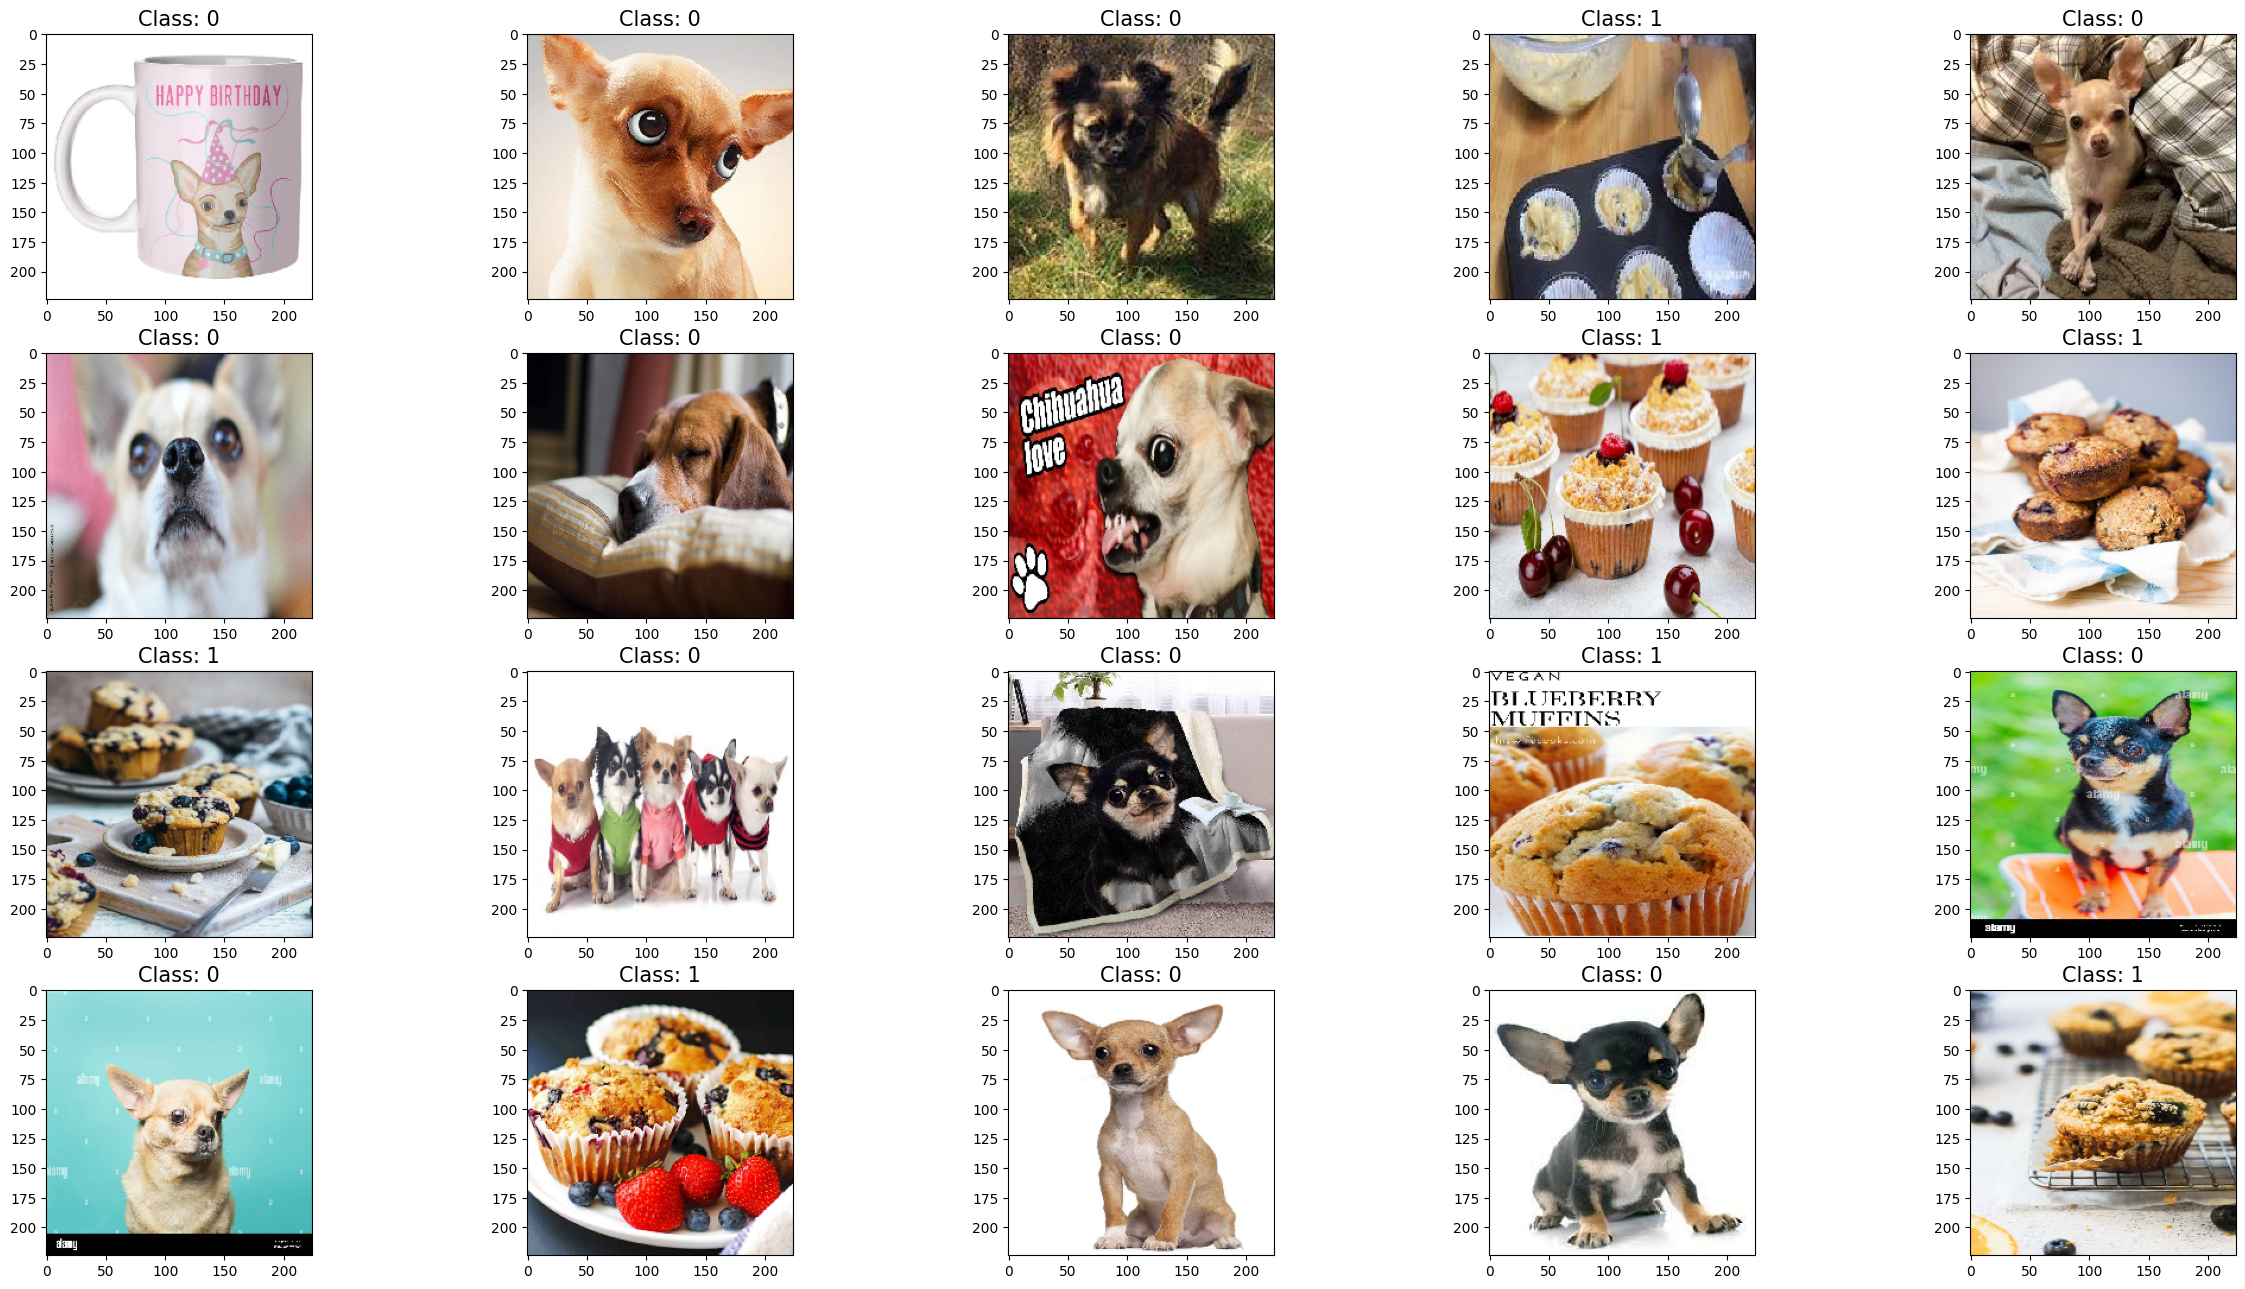

In [7]:
images, labels = next(train_datagen_flow)
images = images[:20]
labels = labels[:20]
cols = 5
rows = int(len(images)/cols) + 1
plt.figure(figsize=(30,20))
index = 1
for image, label in zip(images, labels):
    image = image/255.0
    plt.subplot(rows, cols, index)
    plt.imshow(image)
    plt.title(f'Class: {int(label)}', fontsize = 15);
    index+=1
plt.show()

## Сеть на базе MobileNetV3Small

In [11]:
def muffdog_nn():
    model = Sequential()
    base_model = MobileNetV3Small(include_top= False, input_shape=INPUT_SIZE+(3,), weights='imagenet', pooling= 'max')
    base_model.trainable = False # используем готовые веса бэкбона
    model.add(base_model)
    model.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
    model.add(Dropout(rate= 0.4, seed=SEED))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


In [12]:
model = muffdog_nn()
model.summary()

2023-12-12 10:05:10.824506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-12 10:05:10.824579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: lashkov-mdpc
2023-12-12 10:05:10.824606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: lashkov-mdpc
2023-12-12 10:05:10.824752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.223.2
2023-12-12 10:05:10.824805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.223.2
2023-12-12 10:05:10.824825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.223.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 576)               2304      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1089393 (4.16 MB)
Trainable params: 149121

In [13]:
nn_history = model.fit(train_datagen_flow, validation_data=val_datagen_flow,
                       epochs=N_EPOCHS,
                       steps_per_epoch=len(train_datagen_flow), 
                       validation_steps=len(val_datagen_flow))

Epoch 1/10
74/74 [==============================] - 53s 664ms/step - loss: 3.5106 - acc: 0.9673 - val_loss: 1.2283 - val_acc: 0.9865
Epoch 2/10
74/74 [==============================] - 48s 648ms/step - loss: 0.6539 - acc: 0.9808 - val_loss: 0.3274 - val_acc: 0.9932
Epoch 3/10
74/74 [==============================] - 48s 645ms/step - loss: 0.2726 - acc: 0.9856 - val_loss: 0.2079 - val_acc: 0.9882
Epoch 4/10
74/74 [==============================] - 48s 647ms/step - loss: 0.2074 - acc: 0.9846 - val_loss: 0.1755 - val_acc: 0.9882
Epoch 5/10
74/74 [==============================] - 48s 645ms/step - loss: 0.1757 - acc: 0.9865 - val_loss: 0.1531 - val_acc: 0.9907
Epoch 6/10
74/74 [==============================] - 47s 634ms/step - loss: 0.1587 - acc: 0.9869 - val_loss: 0.1399 - val_acc: 0.9890
Epoch 7/10
74/74 [==============================] - 48s 648ms/step - loss: 0.1451 - acc: 0.9875 - val_loss: 0.1405 - val_acc: 0.9840
Epoch 8/10
74/74 [==============================] - 48s 643ms/step - 

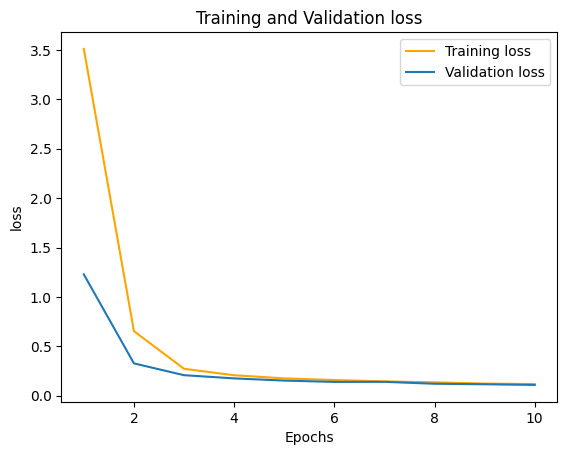

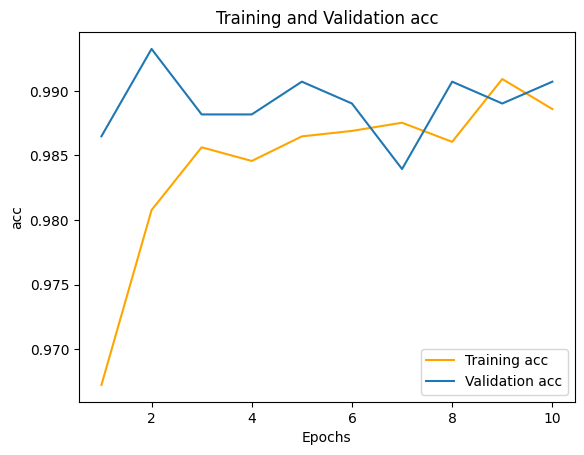

In [14]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    # Построение графика лосса и валидационного лосса
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

check_metrics(nn_history, 'loss')
check_metrics(nn_history, 'acc')

In [15]:
model.save('muffinvschihuahua.keras')

## Тестирование

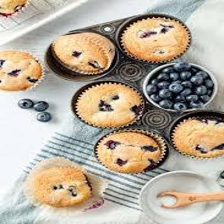

In [16]:
image = Image.open('test/muffin/img_4_972.jpg')
image = image.resize((224, 224))
image

In [17]:
array = np.array(image)[np.newaxis,:,:,:]
print(array.shape)

(1, 224, 224, 3)


In [18]:
reconstructed_model = load_model("muffinvschihuahua.keras")

In [19]:
reconstructed_model.predict(array)

1/1 [==============================] - 1s 841ms/step


array([[0.93086594]], dtype=float32)

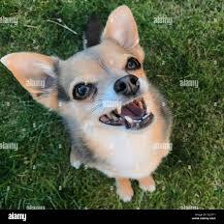

In [20]:
image = Image.open('test/chihuahua/img_4_954.jpg')
image = image.resize((224, 224))
image

In [21]:
array = np.array(image)[np.newaxis,:,:,:]
print(array.shape)

(1, 224, 224, 3)


In [22]:
reconstructed_model.predict(array)

1/1 [==============================] - 0s 39ms/step


array([[0.00084568]], dtype=float32)